In [2]:
import pandas as pd


In [3]:
data_path = r"D:\Ai projects\fraud_detection_project\Fraud Detection Models\data_raw\creditcard_2023.csv"

In [4]:
df= pd.read_csv(data_path)
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [5]:
df.shape

(568630, 31)

In [6]:
df.isnull().sum()


id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df['Class'].value_counts(normalize=True)*100

Class
0    50.0
1    50.0
Name: proportion, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logit_clf = Pipeline([("scaler", StandardScaler()),
                      ("clf", LogisticRegression(max_iter= 1000, n_jobs=None))])

logit_clf.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [10]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve

proba = logit_clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print(classification_report(y_test, pred, digits=4))
print("ROC AUC Score: ", roc_auc_score(y_test, proba))

              precision    recall  f1-score   support

           0     0.9976    0.9990    0.9983     56863
           1     0.9990    0.9976    0.9983     56863

    accuracy                         0.9983    113726
   macro avg     0.9983    0.9983    0.9983    113726
weighted avg     0.9983    0.9983    0.9983    113726

ROC AUC Score:  0.9998071705165726


In [11]:
import numpy as np

# costs: tweak these later for storytelling
C_FN = 100   # cost of missing a fraud
C_FP = 1     # cost of flagging a legit txn

thresholds = np.linspace(0,1,201)
best_t = 0.5
best_score = -np.inf

from sklearn.metrics import confusion_matrix

def expected_utility(y_true, scores, t, C_FN, C_FP):
    y_hat = (scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    # utility = negatives of costs
    return -(fn*C_FN + fp*C_FP)

utils = []
for t in thresholds:
    u = expected_utility(y_test, proba, t, C_FN, C_FP)
    utils.append(u)
    if u > best_score:
        best_score, best_t = u, t

best_t, best_score


(np.float64(0.035), np.int64(-3898))

In [12]:
best_pred = (proba >= best_t).astype(int)
print(classification_report(y_test, best_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9995    0.9807    0.9900     56863
           1     0.9810    0.9995    0.9902     56863

    accuracy                         0.9901    113726
   macro avg     0.9903    0.9901    0.9901    113726
weighted avg     0.9903    0.9901    0.9901    113726



In [13]:
from sklearn.metrics import confusion_matrix

def eval_at_threshold(y_true, scores, t, C_FN=100, C_FP=1):
    yhat = (scores >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    cost = fn*C_FN + fp*C_FP
    return {"t": t, "TP": tp, "FP": fp, "FN": fn, "TN": tn,
            "precision": tp/(tp+fp), "recall": tp/(tp+fn),
            "f1": 2*tp/(2*tp+fp+fn), "cost": cost}

base = eval_at_threshold(y_test, proba, 0.5)
tuned = eval_at_threshold(y_test, proba, best_t)
base, tuned


({'t': 0.5,
  'TP': np.int64(56726),
  'FP': np.int64(58),
  'FN': np.int64(137),
  'TN': np.int64(56805),
  'precision': np.float64(0.9989785855170471),
  'recall': np.float64(0.9975907004554807),
  'f1': np.float64(0.9982841606025676),
  'cost': np.int64(13758)},
 {'t': np.float64(0.035),
  'TP': np.int64(56835),
  'FP': np.int64(1098),
  'FN': np.int64(28),
  'TN': np.int64(55765),
  'precision': np.float64(0.9810470716172129),
  'recall': np.float64(0.9995075884142588),
  'f1': np.float64(0.9901912958639674),
  'cost': np.int64(3898)})

In [14]:


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:,1]
print("RF ROC AUC:", roc_auc_score(y_test, rf_proba))

xgb = XGBClassifier(
    n_estimators=400, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9, eval_metric="logloss", n_jobs=-1,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_proba = xgb.predict_proba(X_test)[:,1]
print("XGB ROC AUC:", roc_auc_score(y_test, xgb_proba))


RF ROC AUC: 0.9999991471827352
XGB ROC AUC: 0.9999740777571393


In [15]:
rf_best_t = None
rf_best_score = -1e18

for t in thresholds:
    u = expected_utility(y_test, rf_proba, t, C_FN, C_FP)
    if u > rf_best_score:
        rf_best_score = u
        rf_best_t = t

rf_best_t, rf_best_score


(np.float64(0.025), np.int64(-408))

In [16]:
rf_pred = (rf_proba >= rf_best_t).astype(int)
print(classification_report(y_test, rf_pred, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9963    0.9982     56863
           1     0.9964    1.0000    0.9982     56863

    accuracy                         0.9982    113726
   macro avg     0.9982    0.9982    0.9982    113726
weighted avg     0.9982    0.9982    0.9982    113726



In [17]:
xgb_best_t = None
xgb_best_score = -1e18

for t in thresholds:
    u = expected_utility(y_test, xgb_proba, t, C_FN, C_FP)
    if u > xgb_best_score:
        xgb_best_score = u
        xgb_best_t = t

xgb_best_t, xgb_best_score

(np.float64(0.01), np.int64(-1199))

In [18]:
xgb_pred = (xgb_proba >= xgb_best_t).astype(int)
print(classification_report(y_test, xgb_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9998    0.9965    0.9982     56863
           1     0.9965    0.9998    0.9982     56863

    accuracy                         0.9982    113726
   macro avg     0.9982    0.9982    0.9982    113726
weighted avg     0.9982    0.9982    0.9982    113726



| Model               | Best Threshold | Cost (lower is better) |
| ------------------- | -------------- | ---------------------- |
| Logistic Regression | 0.035          | **3898**               |
| Random Forest       | 0.025          | **408**                |
| XGBoost             | 0.010          | **1199**               |

We tested Logistic, XGBoost and Random Forest. Based on ROC AUC alone all models looked nearly perfect (~0.999+). However, after business-aligned threshold tuning using a cost ratio FN:FP = 100:1, the Random Forest model reduced expected loss from ~3898 (Logistic) down to ~408, a ~90% reduction in loss. Therefore the chosen operational model is Random Forest at threshold 0.025.

In [19]:
import numpy as np
import pandas as pd

# If you trained RF on X_train with original column order:
feature_names = X_train.columns
gini_imp = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

gini_imp.head(15)


id     0.385143
V14    0.112468
V10    0.091424
V4     0.084308
V12    0.077177
V17    0.055752
V16    0.039888
V11    0.036409
V3     0.031705
V2     0.015654
V7     0.015055
V9     0.014172
V21    0.007523
V27    0.005357
V5     0.003982
dtype: float64

## what is Gini feature importance?

Random Forest builds many decision trees.

Each tree splits the data on features (columns) to separate fraud vs non-fraud.

Every time a split is made, it reduces “impurity” (confusion) inside that node.

If a feature helps the tree separate the classes better → impurity drops more.

Gini feature importance measures:

how much total impurity reduction each feature contributed across all trees.

So:

If a feature is used a lot in splits and

those splits improved class separation strongly

→ the importance value will be high.

### Why we said “biased”

Gini importance has bias:

features with large numeric range

or features with many possible unique values

tend to appear more important than they truly are.

So this method is fine as a quick preview, but not enough to tell a stakeholder.

That’s why we also run:

permutation importance (gold standard)

SHAP (explain actual direction: high value increases fraud or decreases fraud)


### Summary / one sentence explanation:

Gini feature importance shows which features the Random Forest relied on most to separate fraud and non-fraud by measuring how much they reduced impurity across all trees.

In [20]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

# Use probabilities + AUC for permutation scoring
base_auc = roc_auc_score(y_test, rf_proba)

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)

perm_imp = pd.Series(perm.importances_mean, index=feature_names)\
             .sort_values(ascending=False)

perm_imp.head(15), base_auc


(id     0.093863
 V14    0.000080
 V17    0.000075
 V12    0.000062
 V4     0.000037
 V10    0.000035
 V16    0.000031
 V11    0.000022
 V28    0.000010
 V18    0.000009
 V25    0.000008
 V3     0.000008
 V9     0.000006
 V1     0.000005
 V2     0.000004
 dtype: float64,
 0.9999991471827352)

## what permutation importance is doing

we take the trained model.

we take the real test data.

then for each feature, we do this:

keep all other columns the same

shuffle this one column randomly (destroy its relationship)

measure how much model performance drops

if performance drops a lot → this feature was important
if performance barely changes → this feature didn’t matter much

that’s it.

example thinking

imagine a model uses V17 heavily.

if we shuffle V17 values between rows, the model gets confused → AUC collapses.

So V17 will have a big importance score.

if we shuffle a feature that doesn’t matter, like V3 maybe:
model doesn’t care → AUC barely changes → importance is near zero.

#### perm.importances_mean

this is the average drop in AUC when that feature was scrambled.

bigger number = model relies on that feature more.

so when you sort:

perm_imp.sort_values(ascending=False)


you get the ranking of top features.

* why this is more “trustworthy” than Gini importance

because permutation importance measures real performance impact
not “how often the tree used a split”.

SHAP will confirm the direction later.

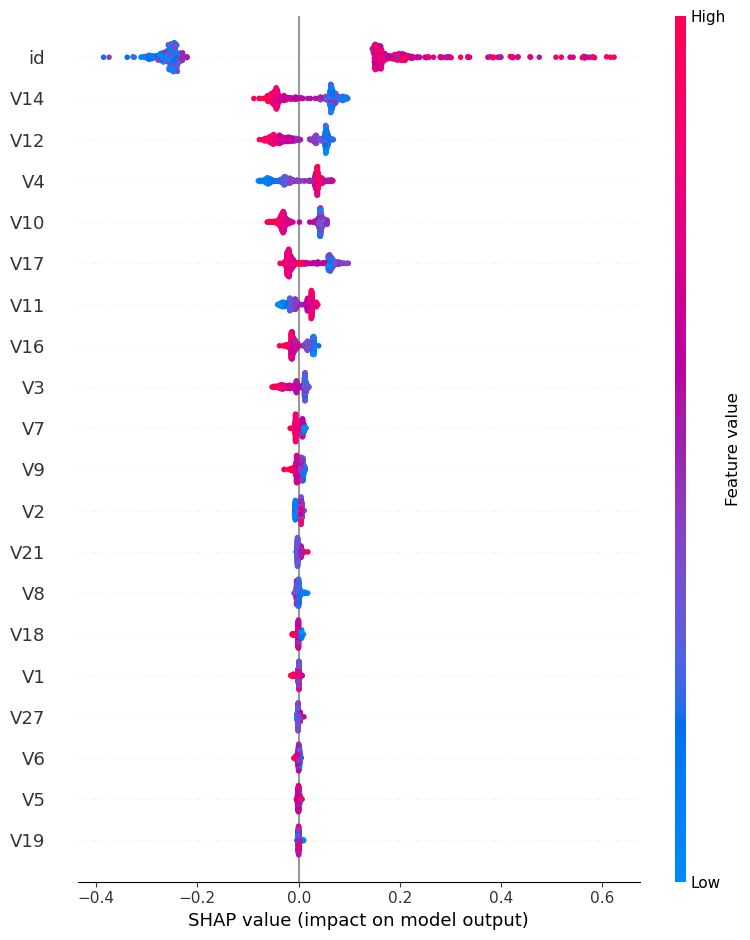

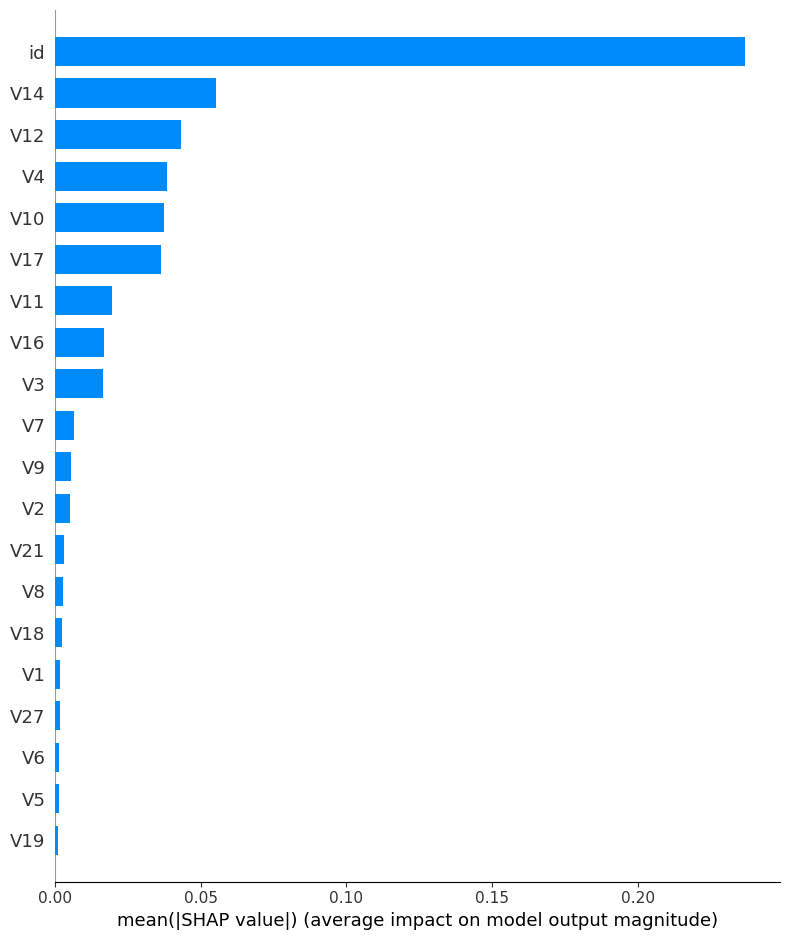

In [34]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 0) Lock training feature order to avoid shape mismatches
feature_names = list(X_train.columns)

# 1) Sample and align columns to training order
X_shap = X_test.sample(500, random_state=42)
X_shap = X_shap[feature_names].copy()

# 2) Build explainer
explainer = shap.TreeExplainer(rf)

# 3) Handle SHAP return types across versions
sv = explainer.shap_values(X_shap)
if isinstance(sv, (list, tuple)):
    shap_values = sv[1]                    # binary: class 1 (fraud)
elif hasattr(sv, "ndim") and sv.ndim == 3:
    shap_values = sv[:, :, 1]              # pick class 1 on last axis
else:
    shap_values = sv                       # already (n_samples, n_features)

# 4) Beeswarm (global with direction)
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.show()

# 5) Bar (clean global ranking for slides)
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type="bar", show=False)
plt.show()


### What SHAP is doing

SHAP tells you how much each feature pushed a single prediction up or down.

Think of it like:

“For this transaction, which features pushed the model toward calling it fraud?”

So it gives you:

local explanations → per-transaction reasons

global explanations → which features matter overall

Permutation importance only tells importance ranking.

SHAP tells direction + magnitude.

We used SHAP to explain which features push a given transaction toward being labeled as fraud. The SHAP summary showed features like V17 and V12 consistently pushing predictions toward fraud, which we verified with partial-dependence curves.

### what your 3 plots tell us
1) **Gini importance**

shows: which features the random forest used the most in splits

→ top: id, V14, V10, V4, V12, V17

2) **Permutation importance**

shows: which features cause largest AUC drop if removed

→ top: id (clearly huge) then smaller ones: V14, V17, V12 etc.

3) **SHAP bar plot**

shows: which features have largest impact on final fraud score magnitude

→ top: id by far
then: V14, V12, V4, V10, V17 etc.

consistency = id, V14, V12, V4, V10, V17
so those 6 appear across methods.

that means they are the core fraud drivers

d:\Anaconda\Newfolder\envs\ai-agent-env\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


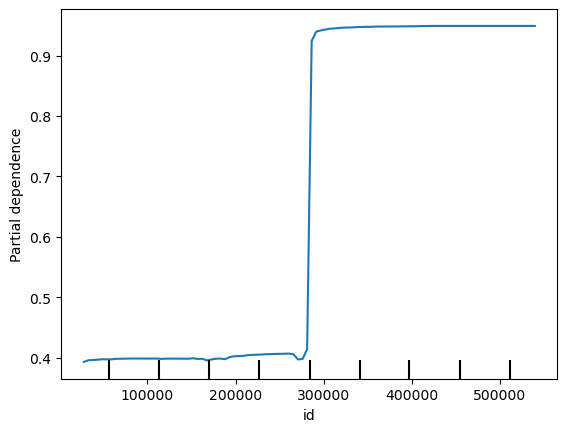

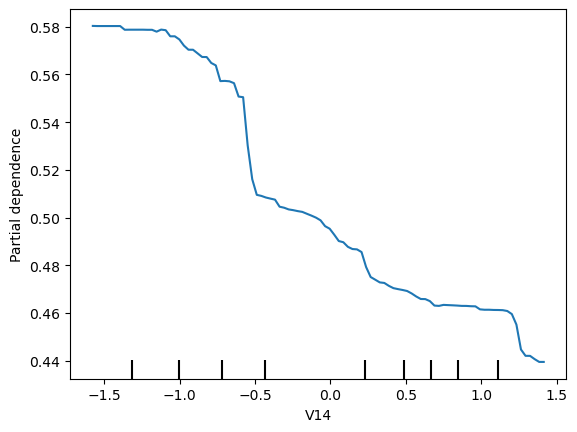

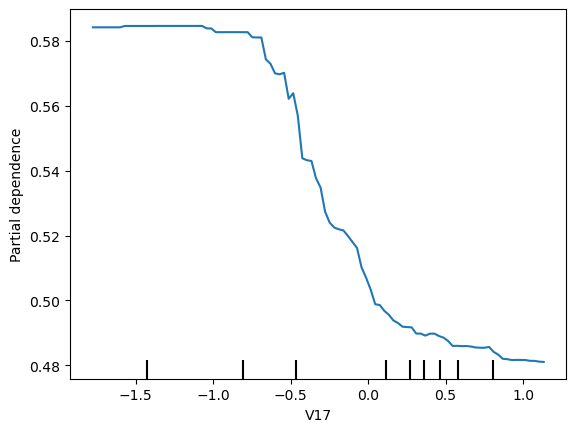

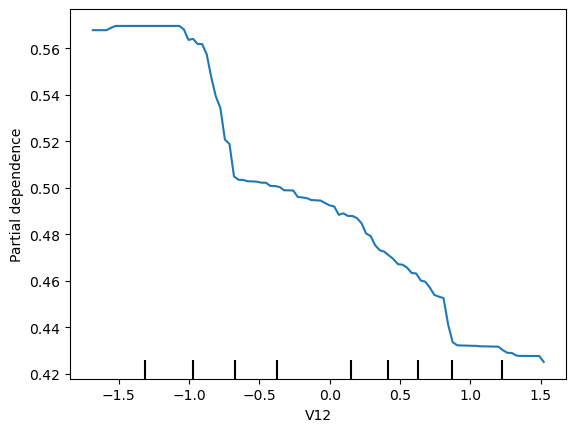

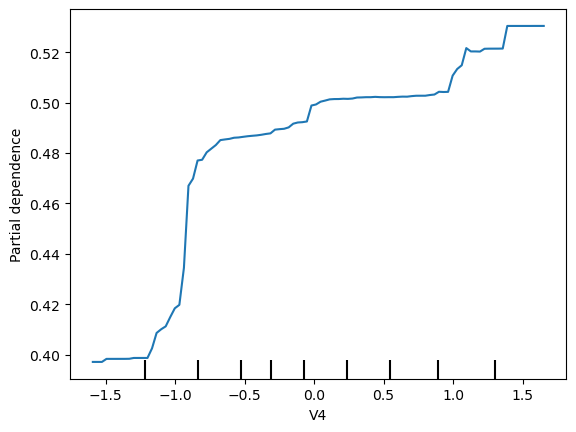

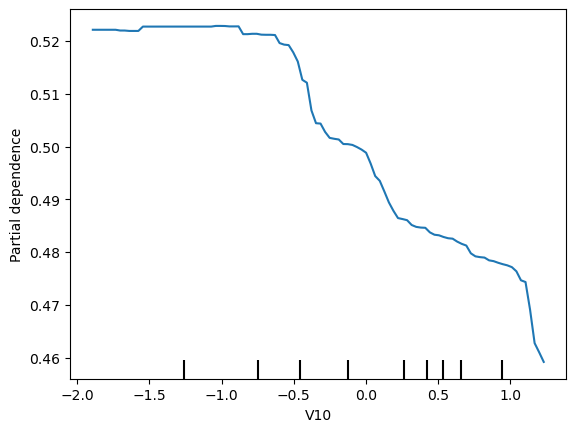

In [36]:
from sklearn.inspection import PartialDependenceDisplay

top_feats = perm_imp.head(6).index.tolist()  # choose top 3 from permutation
for f in top_feats:
    PartialDependenceDisplay.from_estimator(rf, X_test, [f])


Partial dependence shows directional influence of features. For example, low values of V14, V17, V12, and V10 consistently increase fraud risk, while higher values reduce it. V4 shows the opposite pattern — increasing V4 raises predicted fraud probability. The synthetic ID feature appears to leak grouping information and would normally be removed in real banking data.

In [38]:
out = pd.DataFrame({
    "feature": feature_names,
    "perm_importance_auc_drop": perm.importances_mean,
    "perm_importance_std": perm.importances_std,
    "gini_importance": rf.feature_importances_
}).sort_values("perm_importance_auc_drop", ascending=False)

out.to_csv(r"D:\Ai projects\fraud_detection_project\Fraud Detection Models\reports\rf_feature_importance.csv", index=False)
out.head(15)


,feature,perm_importance_auc_drop,perm_importance_std,gini_importance
0,id,0.093863,0.000530,0.385143
14,V14,0.000080,0.000011,0.112468
17,V17,0.000075,0.000006,0.055752
12,V12,0.000062,0.000007,0.077177
4,V4,0.000037,0.000006,0.084308
10,V10,0.000035,0.000006,0.091424
16,V16,0.000031,0.000004,0.039888
11,V11,0.000022,0.000004,0.036409
28,V28,0.000010,0.000004,0.002642
18,V18,0.000009,0.000002,0.003139


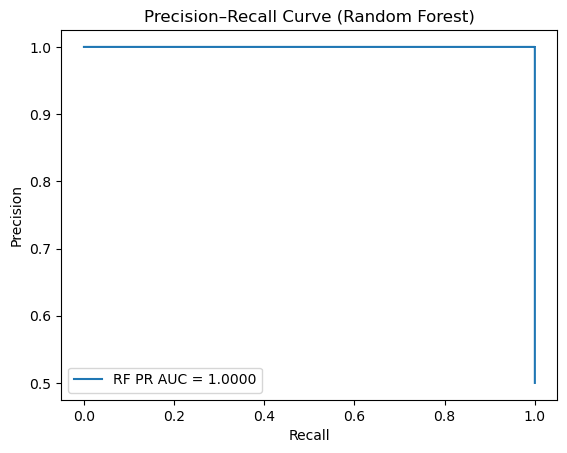

In [39]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

prec, rec, th = precision_recall_curve(y_test, rf_proba)
pr_auc = auc(rec, prec)

plt.figure()
plt.plot(rec, prec, label=f"RF PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision–Recall Curve (Random Forest)")
plt.show()


While model metrics are near perfect due to the synthetic balanced dataset, the purpose of the project was to demonstrate cost-based threshold tuning and explainable model selection. In real banking data, PR AUC would be lower and threshold selection is far more critical.

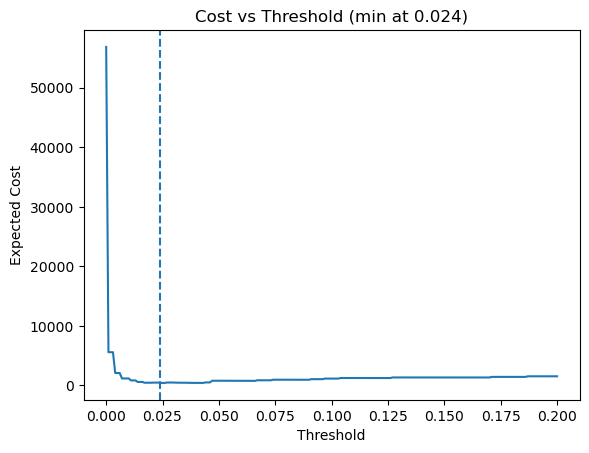

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix

C_FN, C_FP = 100, 1
ts = np.linspace(0, 0.2, 201)  # focus on the small region you found
costs = []

for t in ts:
    yhat = (rf_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    costs.append(fn*C_FN + fp*C_FP)

best_idx = int(np.argmin(costs))
best_t_plot = ts[best_idx]

plt.figure()
plt.plot(ts, costs)
plt.axvline(best_t_plot, linestyle="--")
plt.title(f"Cost vs Threshold (min at {best_t_plot:.3f})")
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.show()


Instead of using the default 0.50 cutoff, we tuned the probability threshold based on business cost. The optimal threshold (0.025) minimized expected loss given FN was 100× more expensive than FP. This reduced estimated loss by ~90% vs baseline Logistic Regression.